# Toronto Neighborhood Segmentation

### Downloading and  Importing libraries

In [2]:
# Downloading neccessary libraries

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

##### Loading relevant Libraries

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
# import lxml.html as lh

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

# # import k-means from clustering stage
# from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import warnings
warnings.filterwarnings("ignore")

##### Scraping the table from wikipedia website

In [170]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# Using Beautiful Soup used for scrapping data off various tags

# response = requests.get(url)

# soup = BeautifulSoup(response.content, 'html.parser')
# tables = soup.find_all('table')

# table = str(tables[0]) #cast table to string
# print(table)

df = pd.read_html(url)[0]
df_copy = df.copy()
print(df.shape)
df.head()

(180, 3)


,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Data Wrangling

In [171]:
# removing Boroughs that are "Not Assigned"
df = df[df['Borough']!='Not assigned']
df[df['Neighborhood']=='Not assigned']['Postal Code'].count()

0

In [172]:
df.groupby('Borough').count()

,Postal Code,Neighborhood
Borough,,
Central Toronto,9,9
Downtown Toronto,19,19
East Toronto,5,5
East York,5,5
Etobicoke,12,12
Mississauga,1,1
North York,24,24
Scarborough,17,17
West Toronto,6,6


In [173]:
df.shape

(103, 3)

##### Getting Latitude and Logitude data for Toronto Neighborhoods

In [174]:
# import geocoder # import geocoder

# # initialize your variable to None
# lat_lng_coords = None

# # loop until you get the coordinates
# while(lat_lng_coords is None):
#   g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#   lat_lng_coords = g.latlng

# latitude = lat_lng_coords[0]
# longitude = lat_lng_coords[1]

In [175]:
latlongurl = "https://cocl.us/Geospatial_data"
df_lat_long = pd.read_csv(latlongurl)

In [176]:
df_lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


##### Joining neighborhood data with latitudes and longitude

In [177]:
df_merged = df.merge(df_lat_long, left_on='Postal Code', right_on='Postal Code', how='left')
df_merged.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [178]:
df_merged[df_merged['Neighborhood']=='Downsview']

,Postal Code,Borough,Neighborhood,Latitude,Longitude
40,M3K,North York,Downsview,43.737473,-79.464763
46,M3L,North York,Downsview,43.739015,-79.506944
53,M3M,North York,Downsview,43.728496,-79.495697
60,M3N,North York,Downsview,43.761631,-79.520999


In [179]:
df_merged.groupby('Neighborhood').count().sort_values('Postal Code', ascending=False).head()

,Postal Code,Borough,Latitude,Longitude
Neighborhood,,,,
Downsview,4,4,4,4
Don Mills,2,2,2,2
Agincourt,1,1,1,1
"Steeles West, L'Amoreaux West",1,1,1,1
St. James Town,1,1,1,1


As we can see from the above output, neighborhoods have duplicate values for Downsview and Don Mills. Will make them unique by concatenating with Postal Code

In [180]:
# Making Neighborhood unique

# df_merged.loc[46]['Neighborhood'] + ', ' + df_merged.loc[46]['Postal Code']   #Testing

for i in df_merged.index:
    if (df_merged.loc[i]['Neighborhood']=='Downsview' or df_merged.loc[i]['Neighborhood']=='Don Mills'):
        df_merged.loc[i,'Neighborhood'] = df_merged.loc[i]['Neighborhood'] + ', ' + df_merged.loc[i]['Postal Code']
    else:
        continue
        

In [181]:
df_merged.groupby('Neighborhood').count().sort_values('Postal Code', ascending=False).head()

,Postal Code,Borough,Latitude,Longitude
Neighborhood,,,,
Agincourt,1,1,1,1
"Parkview Hill, Woodbine Gardens",1,1,1,1
Scarborough Village,1,1,1,1
"Runnymede, The Junction North",1,1,1,1
"Runnymede, Swansea",1,1,1,1


### Viewing Toronto neighborhoods on Map

##### Using geopy library to get the latitude and longitude values of Toronto

In [182]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [183]:
# latitude = 43.6532
# longitude = -79.3832
neighborhoods = df_merged.copy()

In [184]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Using the Foursquare API to get neighborhood venue info

##### Define Foursquare API credentials

In [186]:
CLIENT_ID = 'XL2AC1W50RETHNFTNJFXOFUYVEOB2R0C0N2AOKISV4RVVTQZ' # your Foursquare ID
CLIENT_SECRET = 'VB1FMT151MY15ILDLFSOZAMJUDHOOFBWC5UHAH4SF4EHS2HD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XL2AC1W50RETHNFTNJFXOFUYVEOB2R0C0N2AOKISV4RVVTQZ
CLIENT_SECRET:VB1FMT151MY15ILDLFSOZAMJUDHOOFBWC5UHAH4SF4EHS2HD


##### Getting venue info for Tronoto's neighborhood using Foursquare API

In [188]:
# defining function to exract info from json returned by the API into data frame

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [189]:
# getting nearby venues for Toronto's neighborhoods, define radius and number of venues to extract

rad = 500
lim = 50

toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                 radius=rad,
                                 LIMIT=lim)

In [190]:
toronto_venues.head()

,Hood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


### Analysing Neighborhoods

##### Analysing on common-ness (frequency) of venue types (category) and counts of listed venues

In [191]:
# one-hot encoding to develop venue category frequencies per neighborhood

onehot = pd.get_dummies(toronto_venues['Venue Category'])
toronto_venues_one_hot = pd.concat([toronto_venues['Hood'],onehot], axis=1)

In [192]:
# coding column for total_venues - count and frequency

total_venues_per_hood = toronto_venues_one_hot.groupby('Hood').count()[['Airport']]
total_venues_per_hood.columns = ['total_venues']

proportion_of_venues_per_hood = toronto_venues_one_hot.groupby('Hood').mean()

In [193]:
# built df_model data frame for clustering

df_model = total_venues_per_hood.join(proportion_of_venues_per_hood).reset_index()
df_model.head()

,Hood,total_venues,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
# building df_analyse to showcase 5 most common venues per neighborhood

venues_per_hood = proportion_of_venues_per_hood.reset_index()
temp = pd.DataFrame()

First_Most_Common_Venue_Category = []
Second_Most_Common_Venue_Category = []
Third_Most_Common_Venue_Category = []
Fourth_Most_Common_Venue_Category = []
Fifth_Most_Common_Venue_Category = []

for hood in venues_per_hood['Hood']:
    #print(hood)
    temp = venues_per_hood[venues_per_hood['Hood']==hood].T.reset_index()
    temp.columns = ['venue_category','proportion']
    temp = temp[1:].sort_values(by='proportion',ascending=False)
    #print(temp.iloc[0]['venue_category'])
    First_Most_Common_Venue_Category.append(temp.iloc[0]['venue_category'])
    Second_Most_Common_Venue_Category.append(temp.iloc[1]['venue_category'])
    Third_Most_Common_Venue_Category.append(temp.iloc[2]['venue_category'])
    Fourth_Most_Common_Venue_Category.append(temp.iloc[3]['venue_category'])
    Fifth_Most_Common_Venue_Category.append(temp.iloc[4]['venue_category'])


df_analyse = pd.concat([venues_per_hood['Hood'], total_venues_per_hood.reset_index()['total_venues'], \
                        pd.Series(First_Most_Common_Venue_Category), pd.Series(Second_Most_Common_Venue_Category),\
                        pd.Series(Third_Most_Common_Venue_Category), pd.Series(Fourth_Most_Common_Venue_Category), \
                        pd.Series(Fifth_Most_Common_Venue_Category)], axis=1)

df_analyse.columns = ['Hood', 'total_venues', 
                      'First_Most_Common_Venue_Category', 'Second_Most_Common_Venue_Category',
                      'Third_Most_Common_Venue_Category', 'Fourth_Most_Common_Venue_Category',\
                      'Fifth_Most_Common_Venue_Category']

In [195]:
df_analyse.head()

,Hood,total_venues,First_Most_Common_Venue_Category,Second_Most_Common_Venue_Category,Third_Most_Common_Venue_Category,Fourth_Most_Common_Venue_Category,Fifth_Most_Common_Venue_Category
0,Agincourt,4,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Accessories Store
1,"Alderwood, Long Branch",9,Pizza Place,Pharmacy,Coffee Shop,Pub,Dance Studio
2,"Bathurst Manor, Wilson Heights, Downsview North",19,Bank,Coffee Shop,Pharmacy,Gas Station,Shopping Mall
3,Bayview Village,4,Café,Chinese Restaurant,Bank,Japanese Restaurant,Accessories Store
4,"Bedford Park, Lawrence Manor East",25,Restaurant,Sandwich Place,Italian Restaurant,Thai Restaurant,Coffee Shop


In [196]:
# Testing

# #proportion_of_venues_per_hood.reset_index().loc[0]#.T.reset_index().rename({'index':'venues','0':'freq'}).sort_values('freq',ascending=False)
# venues_per_hood = proportion_of_venues_per_hood.reset_index()
# lis = venues_per_hood[venues_per_hood['Hood']=='Agincourt'].T.reset_index()
# lis.columns = ['category','freq']
# lis[1:].sort_values(by='freq',ascending=False).head(10)#.iloc[0].values

### Running KMeans

##### Determing best number of clusters (k) using elbow method

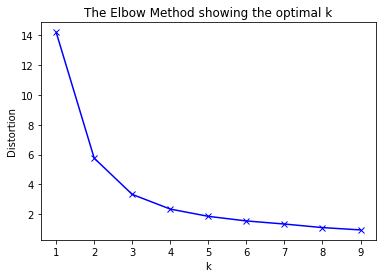

In [197]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


X = df_model.drop('Hood', 1)


# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

##### Running KMeans for best k

In [198]:
# set number of clusters
kclusters = 3

df_model_clustering = df_model.drop('Hood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10).fit(df_model_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 1, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0,
       0, 2, 0, 1, 0, 2, 0, 1, 1, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1, 2, 2, 0, 1, 0, 2, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [199]:
df_analyse['ClusterLabels'] = kmeans.labels_

In [200]:
df_analyse.head()

,Hood,total_venues,First_Most_Common_Venue_Category,Second_Most_Common_Venue_Category,Third_Most_Common_Venue_Category,Fourth_Most_Common_Venue_Category,Fifth_Most_Common_Venue_Category,ClusterLabels
0,Agincourt,4,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Accessories Store,0
1,"Alderwood, Long Branch",9,Pizza Place,Pharmacy,Coffee Shop,Pub,Dance Studio,0
2,"Bathurst Manor, Wilson Heights, Downsview North",19,Bank,Coffee Shop,Pharmacy,Gas Station,Shopping Mall,2
3,Bayview Village,4,Café,Chinese Restaurant,Bank,Japanese Restaurant,Accessories Store,0
4,"Bedford Park, Lawrence Manor East",25,Restaurant,Sandwich Place,Italian Restaurant,Thai Restaurant,Coffee Shop,2


##### Merging df_analyse with latitude and longitude to view clusters on map and further analyse

In [201]:
#df_combine = df_merged.merge(df_model, left_on='Neighborhood', right_on='Hood', how='left')
df_combined = df_merged.merge(df_analyse, left_on='Neighborhood', right_on='Hood', how='left')
df_final = df_combined[['Postal Code', 'Borough', 'Neighborhood', 'Latitude','Longitude', 'total_venues',\
                       'First_Most_Common_Venue_Category','Second_Most_Common_Venue_Category','Third_Most_Common_Venue_Category'\
                      ,'Fourth_Most_Common_Venue_Category','Fifth_Most_Common_Venue_Category','ClusterLabels']]
df_final.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,total_venues,First_Most_Common_Venue_Category,Second_Most_Common_Venue_Category,Third_Most_Common_Venue_Category,Fourth_Most_Common_Venue_Category,Fifth_Most_Common_Venue_Category,ClusterLabels
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Food & Drink Shop,Accessories Store,Monument / Landmark,Martial Arts Dojo,0.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,4.0,Pizza Place,Coffee Shop,Portuguese Restaurant,Hockey Arena,Middle Eastern Restaurant,0.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,45.0,Coffee Shop,Bakery,Park,Theater,Café,1.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,13.0,Clothing Store,Furniture / Home Store,Vietnamese Restaurant,Boutique,Miscellaneous Shop,2.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,30.0,Coffee Shop,Diner,Gym,Fried Chicken Joint,Beer Bar,2.0


In [202]:
df_final.shape

(103, 12)

In [203]:
df_final[df_final['ClusterLabels'].isna()]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,total_venues,First_Most_Common_Venue_Category,Second_Most_Common_Venue_Category,Third_Most_Common_Venue_Category,Fourth_Most_Common_Venue_Category,Fifth_Most_Common_Venue_Category,ClusterLabels
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Foursquare info is not available for the above four postal codes. Hence dropping these columns to remove them from further analyses

In [212]:
df_final.dropna(inplace=True)
df_final.shape

(99, 12)

In [213]:
# converting cluster labels to int and viewing final dataframe

df_final['ClusterLabels'] = df_final['ClusterLabels'].astype(int)
df_final.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,total_venues,First_Most_Common_Venue_Category,Second_Most_Common_Venue_Category,Third_Most_Common_Venue_Category,Fourth_Most_Common_Venue_Category,Fifth_Most_Common_Venue_Category,ClusterLabels
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Food & Drink Shop,Accessories Store,Monument / Landmark,Martial Arts Dojo,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,4.0,Pizza Place,Coffee Shop,Portuguese Restaurant,Hockey Arena,Middle Eastern Restaurant,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,45.0,Coffee Shop,Bakery,Park,Theater,Café,1
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,13.0,Clothing Store,Furniture / Home Store,Vietnamese Restaurant,Boutique,Miscellaneous Shop,2
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,30.0,Coffee Shop,Diner,Gym,Fried Chicken Joint,Beer Bar,2


##### Viewing neighborhoods on map and clusters

In [206]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neighborhood'], df_final['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Drilling into each cluster

In [207]:
df_final[df_final['ClusterLabels']==2]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,total_venues,First_Most_Common_Venue_Category,Second_Most_Common_Venue_Category,Third_Most_Common_Venue_Category,Fourth_Most_Common_Venue_Category,Fifth_Most_Common_Venue_Category,ClusterLabels
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,13.0,Clothing Store,Furniture / Home Store,Vietnamese Restaurant,Boutique,Miscellaneous Shop,2
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,30.0,Coffee Shop,Diner,Gym,Fried Chicken Joint,Beer Bar,2
13,M3C,North York,"Don Mills, M3C",43.725900,-79.340923,23.0,Gym,Restaurant,Coffee Shop,Asian Restaurant,Beer Store,2
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,17.0,Grocery Store,Café,Park,Baby Store,Restaurant,2
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,19.0,Bank,Coffee Shop,Pharmacy,Gas Station,Shopping Mall,2
29,M4H,East York,Thorncliffe Park,43.705369,-79.349372,20.0,Sandwich Place,Indian Restaurant,Gym,Intersection,Coffee Shop,2
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,15.0,Pharmacy,Bakery,Supermarket,Middle Eastern Restaurant,Bar,2
43,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,24.0,Café,Breakfast Spot,Performing Arts Venue,Coffee Shop,Gym,2
47,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,18.0,Gym,Italian Restaurant,Pizza Place,Park,Pub,2
55,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,25.0,Restaurant,Sandwich Place,Italian Restaurant,Thai Restaurant,Coffee Shop,2


In [208]:
df_final[df_final['ClusterLabels']==1]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,total_venues,First_Most_Common_Venue_Category,Second_Most_Common_Venue_Category,Third_Most_Common_Venue_Category,Fourth_Most_Common_Venue_Category,Fifth_Most_Common_Venue_Category,ClusterLabels
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,45.0,Coffee Shop,Bakery,Park,Theater,Café,1
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,50.0,Coffee Shop,Café,Tea Room,Ramen Restaurant,Cosmetics Shop,1
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,50.0,Café,Cosmetics Shop,Restaurant,Gastropub,Creperie,1
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,50.0,Coffee Shop,Cocktail Bar,Pharmacy,Beer Bar,Café,1
23,M4G,East York,Leaside,43.709060,-79.363452,32.0,Coffee Shop,Burger Joint,Bank,Sporting Goods Shop,Furniture / Home Store,1
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,50.0,Coffee Shop,Italian Restaurant,Bubble Tea Shop,Café,Sandwich Place,1
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,50.0,Café,Coffee Shop,Restaurant,Concert Hall,Steakhouse,1
33,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,50.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Juice Bar,Restaurant,1
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,50.0,Aquarium,Coffee Shop,Hotel,Brewery,Park,1
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,43.0,Bar,Asian Restaurant,Vietnamese Restaurant,Restaurant,Men's Store,1


In [209]:
df_final[df_final['ClusterLabels']==0]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,total_venues,First_Most_Common_Venue_Category,Second_Most_Common_Venue_Category,Third_Most_Common_Venue_Category,Fourth_Most_Common_Venue_Category,Fifth_Most_Common_Venue_Category,ClusterLabels
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Food & Drink Shop,Accessories Store,Monument / Landmark,Martial Arts Dojo,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,4.0,Pizza Place,Coffee Shop,Portuguese Restaurant,Hockey Arena,Middle Eastern Restaurant,0
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2.0,Fast Food Restaurant,Print Shop,Accessories Store,Monument / Landmark,Martial Arts Dojo,0
7,M3B,North York,"Don Mills, M3B",43.745906,-79.352188,4.0,Gym,Café,Caribbean Restaurant,Japanese Restaurant,Medical Center,0
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,11.0,Pizza Place,Gastropub,Café,Bank,Intersection,0
10,M6B,North York,Glencairn,43.709577,-79.445073,5.0,Italian Restaurant,Sushi Restaurant,Bakery,Japanese Restaurant,Pub,0
11,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,1.0,Golf Course,Accessories Store,Motel,Martial Arts Dojo,Massage Studio,0
12,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,2.0,Golf Course,Bar,Accessories Store,Monument / Landmark,Martial Arts Dojo,0
14,M4C,East York,Woodbine Heights,43.695344,-79.318389,7.0,Pharmacy,Park,Athletics & Sports,Beer Store,Video Store,0
16,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,4.0,Field,Trail,Tennis Court,Hockey Arena,Accessories Store,0


## Final Observations

Neighborhoods in Toronto have been clustered on the basis of venues density.
1. High venue density neighborhoods - having cafes and coffee shops as the most common venue
2. Medium venue density neighborhoods
3. Low venue density neighborhoods

High venue density neighborhoods are clustered towards Downtown Toronto at Lake Ontario
Medium venue density neighborhoods surround the high venue density neighborhoods on the outside of Downtown Toronto
Low venue density neighborhoods are dispered on the outside of Downtown Toronto away from Lake Ontario where fewer amenities are available.